Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tensor([2, 0, 1, 1, 1, 2, 1, 0, 0])
tensor(1344)


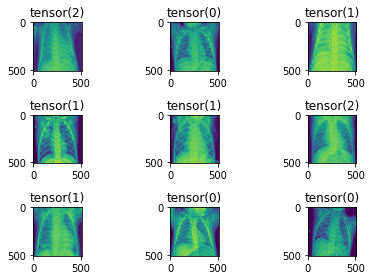

/content/drive/My Drive/Colab Notebooks
importing Jupyter notebook from resNet50.ipynb
torch.Size([2, 1000])
cuda:0
[1,     3] loss: 0.034
[1,     6] loss: 0.029
[1,     9] loss: 0.032
[1,    12] loss: 0.030
[1,    15] loss: 0.039
[1,    18] loss: 0.032
[1,    21] loss: 0.032
[1,    24] loss: 0.037
[1,    27] loss: 0.038
[1,    30] loss: 0.029
[1,    33] loss: 0.038
[1,    36] loss: 0.038
[1,    39] loss: 0.021
[1,    42] loss: 0.034
[1,    45] loss: 0.027
[1,    48] loss: 0.027
[1,    51] loss: 0.034
[1,    54] loss: 0.030
[1,    57] loss: 0.035
[1,    60] loss: 0.028
[1,    63] loss: 0.029
[1,    66] loss: 0.035
[1,    69] loss: 0.027
[1,    72] loss: 0.021
[1,    75] loss: 0.029
[1,    78] loss: 0.032
[1,    81] loss: 0.043
[1,    84] loss: 0.034
[1,    87] loss: 0.036
[1,    90] loss: 0.035
[1,    93] loss: 0.027
[1,    96] loss: 0.030
[1,    99] loss: 0.026
[1,   102] loss: 0.021
[1,   105] loss: 0.027
[1,   108] loss: 0.020
[1,   111] loss: 0.029
[1,   114] loss: 0.039
[1,   117]

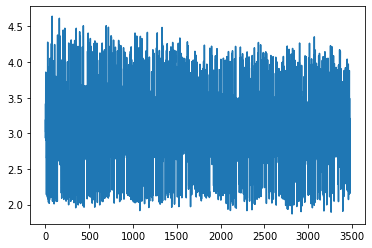

Finished Training
GroundTruth:  tensor(2, device='cuda:0')
Predicted:  tensor([1], device='cuda:0')
GroundTruth:  tensor(0, device='cuda:0')
Predicted:  tensor([1], device='cuda:0')
GroundTruth:  tensor(1, device='cuda:0')
Predicted:  tensor([1], device='cuda:0')
Accuracy of the network on the 5215 test images (2530/5215) : 48.51 %
Accuracy of     0  (0/1341) : 0.00 %
Accuracy of     1  (2530/2530) : 100.00 %
Accuracy of     2  (0/1344) : 0.00 %


In [1]:
import torch
import torchvision
import h5py
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')


train_model = True
save_model = False
load_saved_model = False
no_out_classes = 3


train_set_img = []
train_set_label = []

def load_train_dataset():
    global train_set_img, train_set_label
    dataset_path = '/content/drive/My Drive/pneumonia_chest_X_ray_512x512_trainingDataset.h5'
    # dataset_path = '/content/drive/My Drive/charRecogTrainingDataset.h5'

    train_dataset = h5py.File(dataset_path, 'r')         # test set
    train_set_img = np.array(train_dataset['trainingset_image'][:]) # train set features
    train_set_label = np.array(train_dataset['trainingset_label'][:]) # train set labels

    train_set_img = torch.FloatTensor(train_set_img)
    train_set_label = train_set_label.astype(np.int)
    train_set_label = torch.LongTensor(train_set_label)

    print(train_set_label[0:9])
    print((train_set_label == torch.tensor(2)).sum())
    # print(names_set[0:9])

    # for i in range(500,505):
    #   plt.imshow(np.transpose(img_set[i], (1, 2, 0)))
    #   plt.show()

    i = 0
    rows = 3
    cols = 3
    axes = []
    fig=plt.figure()
    for a in range(rows*cols):
        b = train_set_img[i]
        axes.append( fig.add_subplot(rows, cols, a+1) )

        subplot_title=(str(train_set_label[i]))
        axes[-1].set_title(subplot_title)
         
        i += 1
        b = b.squeeze(0)
        b = b.numpy() # pyTorch tensor to numpy 
        #b = np.moveaxis(b, 0, 2)
        plt.imshow(b.astype('uint8'))
    fig.tight_layout()    
    plt.show()

load_train_dataset()


%pip install import_ipynb
import import_ipynb
%cd /content/drive/My\ Drive/Colab\ Notebooks

from resNet50 import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = ResNet50(img_channels=1, num_classes=no_out_classes).to(device)


### Define a Loss function and optimizer ###

import torch.optim as optim
weights = torch.tensor([1.88, 1., 1.88])
# weights = torch.tensor([1./1341, 1./2530, 1./1344])
# weights = torch.tensor([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
# optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.0000001)

### Train the network ###
def modelTraining():
  loss_values=[]
  for epoch in range(2):  # loop over the dataset multiple times
      running_loss = 0.0
      for i in range(len(train_set_label)):

          # get the inputs
          inputs = train_set_img[i]
          #inputs /= 255.0
          inputs = inputs.unsqueeze(0)

          labels = train_set_label[i]
          labels = torch.tensor([labels])

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs.to(device)).to(device)   # forward

          loss = criterion(outputs.to(device), labels.to(device))
          loss.backward()                             # backward
          optimizer.step()                            # optimize

          # print statistics
          running_loss += loss.item()
          if i % 3 == 2:    # print every 100 mini-batches
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
              loss_values.append(running_loss)
              running_loss = 0.0

  plt.plot(loss_values)
  plt.show()        
        
  print('Finished Training')

if train_model:
  modelTraining()
  
# save trained model:
PATH = '/content/drive/My Drive/pneumonia_training.pth'

if save_model:
  torch.save(net.state_dict(), PATH)

# load back the saved model
if load_saved_model:
  # net = Net()
  net.load_state_dict(torch.load(PATH))

## TEST on only few/single Dataset
test_images = [train_set_img[2], train_set_img[0], train_set_img[1]]
labels = [train_set_label[2],train_set_label[0],train_set_label[1]]
for i, image in enumerate(test_images):
    test_image = image
    test_image = test_image.unsqueeze(0)

    outputs = net(test_image.to(device))
    _, predicted = torch.max(outputs, 1)
    
    print('GroundTruth: ', train_set_label[i].to(device) )
    print('Predicted: ',  predicted.to(device) )


# network performance on the whole dataset,
# AND accuracy of all classes
correct = 0
total = 0
class_correct = list(0. for i in range(no_out_classes))
class_total = list(0. for i in range(no_out_classes))
with torch.no_grad():
    for i in range(len(train_set_label)):
        images = train_set_img[i]
        images = images.unsqueeze(0)

        labels = train_set_label[i]
        labels = torch.tensor([labels])

        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)

        # ----------------- for overall accuracy of model -----------------
        total += labels.size(0)
        correct += (predicted.to(device) == labels.to(device)).sum().item()
        # ------- ------- ---------- -------- --------- --------- ---------

        # ----------------- for accuracy of each classes -------------------
        c = (predicted.to(device) == labels.to(device)).squeeze()
        class_correct[labels] += c.item()
        class_total[labels] += 1
        # ------- ------- ---------- -------- --------- --------- ---------

print('Accuracy of the network on the '+str(len(train_set_label))+' test images (%d/%d) : %.2f %%' % (correct, total ,100 * correct / total))

for i in range(no_out_classes):
    print('Accuracy of %5s  (%d/%d) : %.2f %%' % (i, class_correct[i], class_total[i] ,100 * class_correct[i] / class_total[i]))